# **1. Problem Statement** : Develop a Price Prediction Model
### **Data Overview** : 
There are two files `train.csv` and `test.csv`. Each row of the train.tsv file has the following attributes/features that lists details about a particular product.

*   id: the id of the listing
*   name: the title of the listing
*   item_condition_id: the condition of the items provided by the seller
*   category_name: category of the listing
*   brand_name: brand of the listing
*   price: the price (USD) that the item was sold for
*   shipping: 1 if shipping fee is paid by seller and 0 by buyer
*   item_description: the full description of the listing
*   seller_id: the seller ID of the listing

**Error metric**: RMSLE (Root Mean Square Logarithmic Error)

**Input Features** :  id, name, item_condition_id, category_name, brand_name, shipping, seller_id, item_description

**Target Variable** : price

- For a given item name, here the task is to suggest the price of that item by analysing its different features like category, name, brand name, item description etc. 
- The given problem is a **Regression problem** as it will return the price of an item which is a real-valued value.










In [426]:
# Importing the necessary library 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer


In [427]:
# loading the files
train_data = pd.read_csv("/content/drive/MyDrive/mercari_train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/mercari_test.csv")

# **2. Data Overview**

In [428]:
print('Shape of the training data:', train_data.shape)

Shape of the training data: (68400, 9)


In [429]:
print('Shape of the testing data:', test_data.shape)

Shape of the testing data: (31789, 8)


- train.csv has 68400 rows 
- test.csv has 31789 rows

In [430]:
train_data.head()

,id,name,item_condition_id,category_name,brand_name,price,shipping,seller_id,item_description
0,17,"Hold Alyssa Frye Harness boots 12R, Sz 7",3,Women/Shoes/Boots,Frye,79,1,211140753,Good used condition Women's Fyre harness boots...
1,19,Steve Madden booties,3,Women/Shoes/Boots,Steve Madden,31,0,3874531266,"The brand is actually ""Steven"" by Steve Madden..."
2,42,BCBG Tan Booties,1,Women/Shoes/Boots,NaN,48,0,8341537216,Brand new! Does not include the box.
3,45,NWT Sorel Caribou boots size 8.5,1,Women/Shoes/Boots,NaN,85,0,4040379892,New in box. Size 8.5
4,58,NIB Hunter Tiffany Mint Boots Size 5,1,Women/Shoes/Boots,Hunter,200,0,19216599,Brand new never worn only flaw is as you can s...


In [431]:
test_data.head()

,id,name,item_condition_id,category_name,brand_name,shipping,seller_id,item_description
0,46,Corral boots,2,Women/Shoes/Boots,NaN,0,2261402465,Corral boots in excellent condition barely used
1,88,Vince Camuto Riding boots size 6,2,Women/Shoes/Boots,Vince Camuto,0,2021876312,super cute brown or cognac knee high riding bo...
2,212,Brand new UGG boots,1,Women/Shoes/Boots,UGG Australia,0,5803720303,New in box
3,289,"LL Bean Boots 8"" Red sz 7M",3,Women/Shoes/Boots,L.L. Bean,0,1065939786,Made to withstand winter climate.
4,299,Black UGGS cargo boot,3,Women/Shoes/Boots,UGG Australia,1,479394728,"Unique, super cute and warm! EUC. Only selling..."


### **General overview of the data:**

In [432]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68400 entries, 0 to 68399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 68400 non-null  int64 
 1   name               68400 non-null  object
 2   item_condition_id  68400 non-null  int64 
 3   category_name      68400 non-null  object
 4   brand_name         46935 non-null  object
 5   price              68400 non-null  int64 
 6   shipping           68400 non-null  int64 
 7   seller_id          68400 non-null  int64 
 8   item_description   61590 non-null  object
dtypes: int64(5), object(4)
memory usage: 4.7+ MB


In [433]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31789 entries, 0 to 31788
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 31789 non-null  int64 
 1   name               31789 non-null  object
 2   item_condition_id  31789 non-null  int64 
 3   category_name      31789 non-null  object
 4   brand_name         21894 non-null  object
 5   shipping           31789 non-null  int64 
 6   seller_id          31789 non-null  int64 
 7   item_description   28719 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.9+ MB


In [434]:
train_data.nunique()

id                   68400
name                 59282
item_condition_id        5
category_name           23
brand_name            1083
price                  230
shipping                 2
seller_id            42161
item_description     57531
dtype: int64

In [435]:
test_data.nunique()

id                   31789
name                 28693
item_condition_id        5
category_name           23
brand_name             814
shipping                 2
seller_id            23602
item_description     27068
dtype: int64

In [436]:
submission_final= pd.DataFrame(test_data['id'])
submission_final.head(5)

,id
0,46
1,88
2,212
3,289
4,299


### **Check for duplicate rows**

In [437]:
train_data.duplicated().any()

False

No duplicate rows present in the train dataset

### **Checking for null values in the data set:**


In [438]:
train_data.isnull().sum()

id                       0
name                     0
item_condition_id        0
category_name            0
brand_name           21465
price                    0
shipping                 0
seller_id                0
item_description      6810
dtype: int64

In [439]:
test_data.isnull().sum()

id                      0
name                    0
item_condition_id       0
category_name           0
brand_name           9895
shipping                0
seller_id               0
item_description     3070
dtype: int64

- Here, We can see that the columns ‘brand_name’ and ‘item_description’ have null values. There are different techniques of dealing with missing values like removal of the rows with values missing, remove the feature with a high percentage of missing values or fill the columns with missing values by some other values. Here, we have chosen to fill these missing values in the data by some other value.

- The function `replace_null_value` fills all the columns ‘brand_name’ and ‘item_description’ that have null values with some optional values.

In [440]:
def replace_null_value(data):
  data.brand_name.fillna(value = 'missing', inplace = True)
  data.item_description.fillna(value = 'No description given', inplace = True)
  return data

In [441]:
train_data = replace_null_value(train_data)
print(np.shape(train_data))
train_data.head()

(68400, 9)


,id,name,item_condition_id,category_name,brand_name,price,shipping,seller_id,item_description
0,17,"Hold Alyssa Frye Harness boots 12R, Sz 7",3,Women/Shoes/Boots,Frye,79,1,211140753,Good used condition Women's Fyre harness boots...
1,19,Steve Madden booties,3,Women/Shoes/Boots,Steve Madden,31,0,3874531266,"The brand is actually ""Steven"" by Steve Madden..."
2,42,BCBG Tan Booties,1,Women/Shoes/Boots,missing,48,0,8341537216,Brand new! Does not include the box.
3,45,NWT Sorel Caribou boots size 8.5,1,Women/Shoes/Boots,missing,85,0,4040379892,New in box. Size 8.5
4,58,NIB Hunter Tiffany Mint Boots Size 5,1,Women/Shoes/Boots,Hunter,200,0,19216599,Brand new never worn only flaw is as you can s...


In [442]:
test_data = replace_null_value(test_data)
print(np.shape(test_data))
test_data.head()

(31789, 8)


,id,name,item_condition_id,category_name,brand_name,shipping,seller_id,item_description
0,46,Corral boots,2,Women/Shoes/Boots,missing,0,2261402465,Corral boots in excellent condition barely used
1,88,Vince Camuto Riding boots size 6,2,Women/Shoes/Boots,Vince Camuto,0,2021876312,super cute brown or cognac knee high riding bo...
2,212,Brand new UGG boots,1,Women/Shoes/Boots,UGG Australia,0,5803720303,New in box
3,289,"LL Bean Boots 8"" Red sz 7M",3,Women/Shoes/Boots,L.L. Bean,0,1065939786,Made to withstand winter climate.
4,299,Black UGGS cargo boot,3,Women/Shoes/Boots,UGG Australia,1,479394728,"Unique, super cute and warm! EUC. Only selling..."


In [443]:
train_data.isna().sum()

id                   0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
seller_id            0
item_description     0
dtype: int64

In [444]:
test_data.isna().sum()

id                   0
name                 0
item_condition_id    0
category_name        0
brand_name           0
shipping             0
seller_id            0
item_description     0
dtype: int64

- The category names are listed by ‘/’ delimiter which tells about the main category, sub-category 1 and sub-category 2 of the products. Therefore, to get better idea of each product, we will do feature engineering here and split the category name into 3 different columns namely, ` main_category` , `subcat_0` and `subcat_1`.

In [445]:
def split_category(row):
    try: 
      text = row
      text0, text1, text2 =  text.split('/')
      return text0, text1, text2
    except: 
      return ('No Label given', 'No Label given', 'No Label given') 

In [446]:
train_data['main_category'], train_data['subcat_0'], train_data['subcat_1'] = zip(*train_data['category_name'].apply(lambda x: split_category(x)))
train_data.head()

,id,name,item_condition_id,category_name,brand_name,price,shipping,seller_id,item_description,main_category,subcat_0,subcat_1
0,17,"Hold Alyssa Frye Harness boots 12R, Sz 7",3,Women/Shoes/Boots,Frye,79,1,211140753,Good used condition Women's Fyre harness boots...,Women,Shoes,Boots
1,19,Steve Madden booties,3,Women/Shoes/Boots,Steve Madden,31,0,3874531266,"The brand is actually ""Steven"" by Steve Madden...",Women,Shoes,Boots
2,42,BCBG Tan Booties,1,Women/Shoes/Boots,missing,48,0,8341537216,Brand new! Does not include the box.,Women,Shoes,Boots
3,45,NWT Sorel Caribou boots size 8.5,1,Women/Shoes/Boots,missing,85,0,4040379892,New in box. Size 8.5,Women,Shoes,Boots
4,58,NIB Hunter Tiffany Mint Boots Size 5,1,Women/Shoes/Boots,Hunter,200,0,19216599,Brand new never worn only flaw is as you can s...,Women,Shoes,Boots


In [447]:
test_data['main_category'], test_data['subcat_0'], test_data['subcat_1'] = zip(*test_data['category_name'].apply(lambda x: split_category(x)))
test_data.head()

,id,name,item_condition_id,category_name,brand_name,shipping,seller_id,item_description,main_category,subcat_0,subcat_1
0,46,Corral boots,2,Women/Shoes/Boots,missing,0,2261402465,Corral boots in excellent condition barely used,Women,Shoes,Boots
1,88,Vince Camuto Riding boots size 6,2,Women/Shoes/Boots,Vince Camuto,0,2021876312,super cute brown or cognac knee high riding bo...,Women,Shoes,Boots
2,212,Brand new UGG boots,1,Women/Shoes/Boots,UGG Australia,0,5803720303,New in box,Women,Shoes,Boots
3,289,"LL Bean Boots 8"" Red sz 7M",3,Women/Shoes/Boots,L.L. Bean,0,1065939786,Made to withstand winter climate.,Women,Shoes,Boots
4,299,Black UGGS cargo boot,3,Women/Shoes/Boots,UGG Australia,1,479394728,"Unique, super cute and warm! EUC. Only selling...",Women,Shoes,Boots


# **3. Exploratery Data analysis**

### **3.1 : Basic EDA: Analyzing columns of train data**

## **3.1.1 : name**

In [448]:
train_data.name.describe()

count      68400
unique     59282
top       Bundle
freq         114
Name: name, dtype: object

- There are 59282 unique product names in the raw data(before pre-processing). The most common product name is “Bundle”, which occurs in 114 data points.

## **3.1.2 : item_condition_id**

In [449]:
train_data.item_condition_id.describe()

count    68400.000000
mean         2.131652
std          0.839697
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: item_condition_id, dtype: float64

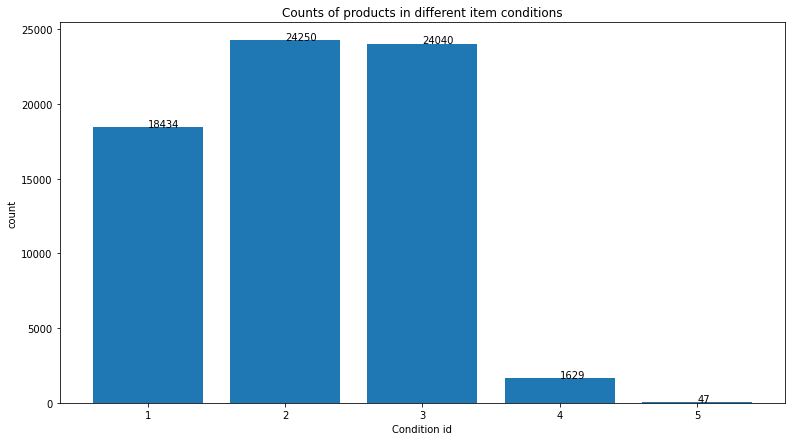

In [450]:
condition_count = Counter(list(train_data.item_condition_id))
x, y = zip(*condition_count.most_common())
plt.figure(figsize=[13,7])
plt.bar(x,y)
for i, val in enumerate(y):
  plt.annotate(val, (x[i], y[i]))
plt.title('Counts of products in different item conditions')
plt.xlabel('Condition id')
plt.ylabel('count')

plt.show()

- The majority of the items are in condition 2 and 3. There are very few items which are in condition 5.

## **3.1.3 : brand_name**

In [451]:
train_data.brand_name.describe()

count       68400
unique       1084
top       missing
freq        21465
Name: brand_name, dtype: object

In [452]:
brand_missing = train_data[train_data.brand_name == 'missing'].shape[0]
print('Brand name is missing for {} datapoints, {:.2f} % of train data'.format(brand_missing, 100.0*brand_missing/train_data.shape[0]))

Brand name is missing for 21465 datapoints, 31.38 % of train data


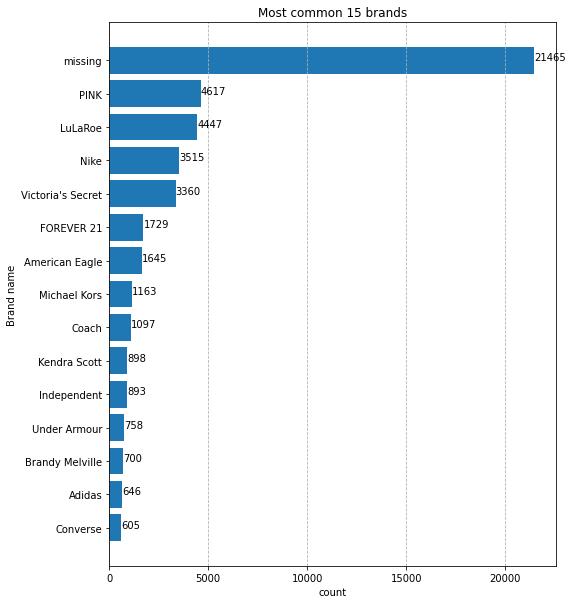

In [453]:
brand_count = Counter(list(train_data.brand_name.values))
x, y = zip(*brand_count.most_common(15))

plt.figure(figsize=[8,10])
plt.barh(x,y)
for i, val in enumerate(y):
  plt.annotate(val, (y[i], x[i]))
plt.gca().invert_yaxis()
plt.title('Most common 15 brands')
plt.ylabel('Brand name')
plt.xlabel('count')
plt.grid(axis = 'x', linestyle = '--')
plt.show()

- Through this distribution plot, we can understand that most of the product listed without brand name.

## **3.1.4 : price**

- This is the target variable or ‘y’ in our train data. We need to predict this for test data. So it is important to analysis the price distribution.

In [454]:
# invalid price
train_data.price.describe()

count    68400.000000
mean        22.881915
std         28.613151
min          3.000000
25%          9.000000
50%         15.000000
75%         28.000000
max       1375.000000
Name: price, dtype: float64

- So, from the describe table we can conclude that:

 - 25% of the products are priced below 10 dollar.
 - 50% of products are priced almost 15 dollar.  
 - 75% of products are priced listed as 28 dollar.
 -  Also, the maximum price that any product has is 1375$.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


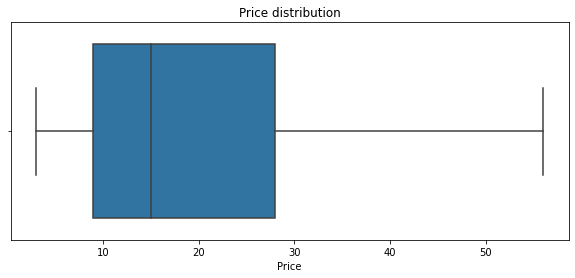

In [455]:
plt.figure(figsize=[10,4])
plt.title('Price distribution')
sns.boxplot(train_data.price,showfliers=False)
plt.xlabel('Price')

plt.show()

- We can see most of the items have the price value between 25-28.And all the items have their price listings between 8-28

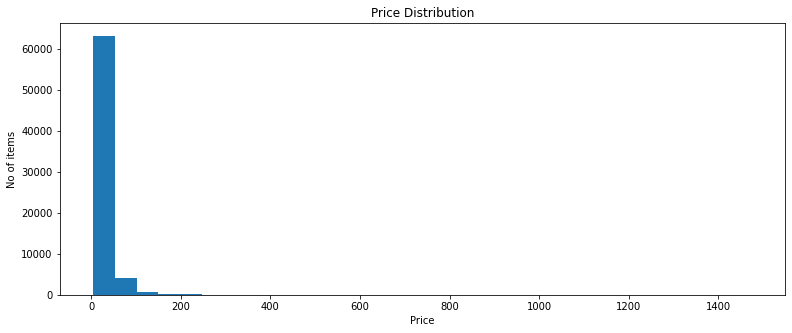

In [456]:
# Price distribution Histogram
fig, ax = plt.subplots(figsize=(13,5))
ax.hist(train_data.price,bins=30,range=[min(train_data.price), max(train_data.price)+100],label='Price')
plt.title('Price Distribution')
ax.set_xlabel('Price')
ax.set_ylabel('No of items')

plt.show()

## outliers present till 1400

- It can concluded that the distribution of the ‘price’ variable is heavily right-skewed. As the ‘price’ variable followed a skewed distribution , in order to make errors on low price product more relevant than for higher prices, the metric of evaluation use is Root Mean Squared Logarithmic Error (RMSLE). 
- Thus, I applied the log transformation to the price target variable, to make this assumption available for model training.So, we have to scale down the ‘price’ feature to log scale.

In [457]:
train_data['log_price'] = np.log(train_data['price']+1)

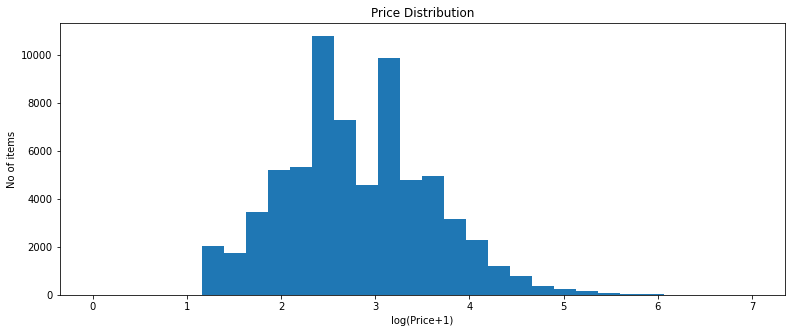

In [458]:
# Price distribution Histogram using log(price+1)
fig, ax = plt.subplots(figsize=(13,5))
ax.hist(train_data.log_price,bins=30,range=[0,7],label='Price')
plt.title('Price Distribution')
plt.xlabel('log(Price+1)')
plt.ylabel('No of items')

plt.show()

- Histogram gives a better representation than box-plot and doesn’t look skewed anymore on changing it to log scale. 

In [459]:
# price percentage
for i in range(0, 100, 10):
  var = train_data['price'].values
  var = np.sort(var)
  le = len(var)
  print('{} percentile of items have price {} USD'.format(i, var[int(le*(float(i)/100))]))


0 percentile of items have price 3 USD
10 percentile of items have price 5 USD
20 percentile of items have price 8 USD
30 percentile of items have price 10 USD
40 percentile of items have price 12 USD
50 percentile of items have price 15 USD
60 percentile of items have price 20 USD
70 percentile of items have price 25 USD
80 percentile of items have price 32 USD
90 percentile of items have price 45 USD


In [460]:
for i in range(90, 100, 1):
  var = train_data['price'].values
  var = np.sort(var)
  le = len(var)
  print('{} percentile of items have price {} USD'.format(i, var[int(le*(float(i)/100))]))
print('100 percentile of items have price ', var[-1])

90 percentile of items have price 45 USD
91 percentile of items have price 50 USD
92 percentile of items have price 50 USD
93 percentile of items have price 55 USD
94 percentile of items have price 60 USD
95 percentile of items have price 64 USD
96 percentile of items have price 70 USD
97 percentile of items have price 80 USD
98 percentile of items have price 90 USD
99 percentile of items have price 124 USD
100 percentile of items have price  1375


- From this analysis we can understand, 99 percentile of the items have a price lower than $125. 

## **3.1.5 : item_description**

In [461]:
train_data.item_description.describe()

count                    68400
unique                   57532
top       No description given
freq                      6810
Name: item_description, dtype: object

In [462]:
description_missing = train_data[train_data.item_description == 'No description given'].shape[0]
print('Item description is missing for {} datapoints, {:.3f} % of train data.'.format(description_missing, 100.0*description_missing/train_data.shape[0]))

Item description is missing for 6810 datapoints, 9.956 % of train data.


## **3.1.6 : Shipping**

In [463]:
print("0: shipping charges paid by seller")
print("1: shipping charges paid by buyers")
print("COUNT:\n",train_data['shipping'].value_counts())
print("Fraction:\n",train_data['shipping'].value_counts(normalize=True))

0: shipping charges paid by seller
1: shipping charges paid by buyers
COUNT:
 0    42748
1    25652
Name: shipping, dtype: int64
Fraction:
 0    0.624971
1    0.375029
Name: shipping, dtype: float64


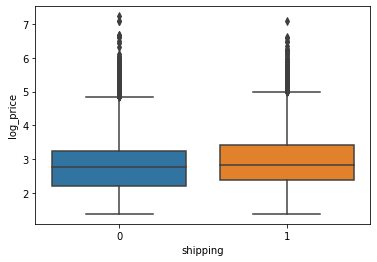

In [464]:
#Boxplot shipping vs logPrice
sns.boxplot(x=train_data.shipping,y=train_data.log_price,orient='v') 

- Here, we can see that for items which have lesser price, the shipping had to be paid by the buyer for profit reasons. Also, as the price increases, we can see that the shipping charges have been paid by the seller. This trend is what is usually observed when we buy products online and our ‘price’ value is less than a certain threshold for free shipping.

## **3.1.6 : Analysis the sub-categories**

In [465]:
# main category analysis
train_data.main_category.describe()

count     68400
unique        1
top       Women
freq      68400
Name: main_category, dtype: object

- Main Category only consist Women category product.


In [466]:
train_data.subcat_0.describe()

count              68400
unique                11
top       Tops & blouses
freq               16637
Name: subcat_0, dtype: object

- In ‘Subcategory 0’, there are about 11 unique categories. Exploring items distribution with highest frequency in Subcategory-1.

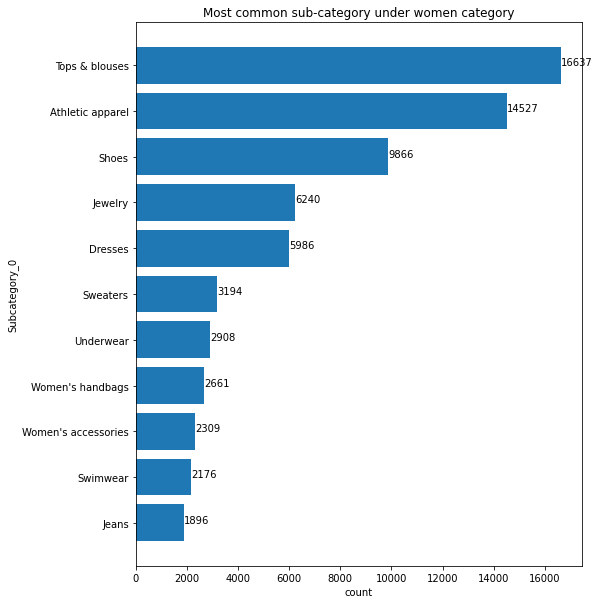

In [467]:
subcat0_count = Counter(list(train_data.subcat_0.values))
x, y = zip(*subcat0_count.most_common(11))

plt.figure(figsize=[8,10])
plt.barh(x,y)
for i, val in enumerate(y):
  plt.annotate(val, (y[i], x[i]))
plt.gca().invert_yaxis()
plt.title('Most common sub-category under women category')
plt.ylabel('Subcategory_0')
plt.xlabel('count')

plt.show()

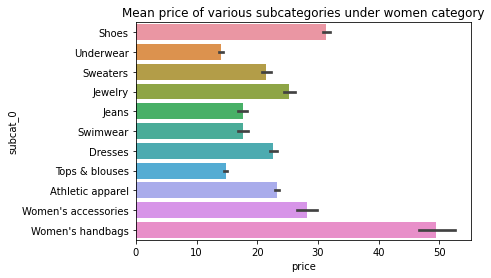

In [468]:
plt.figure()
sns.barplot(y='subcat_0', x='price',data=train_data)
plt.title('Mean price of various subcategories under women category')
plt.show()

- Here we can observe under women category, women's handbag has highest price with 2661 items sold. Whereas top & blouses is the most buying product with priced less than 20 dollars.

In [469]:
train_data.subcat_1.describe()

count                       68400
unique                         23
top       Pants, tights, leggings
freq                         9371
Name: subcat_1, dtype: object

- In ‘Subcategory 1’, there are about 23 unique categories.

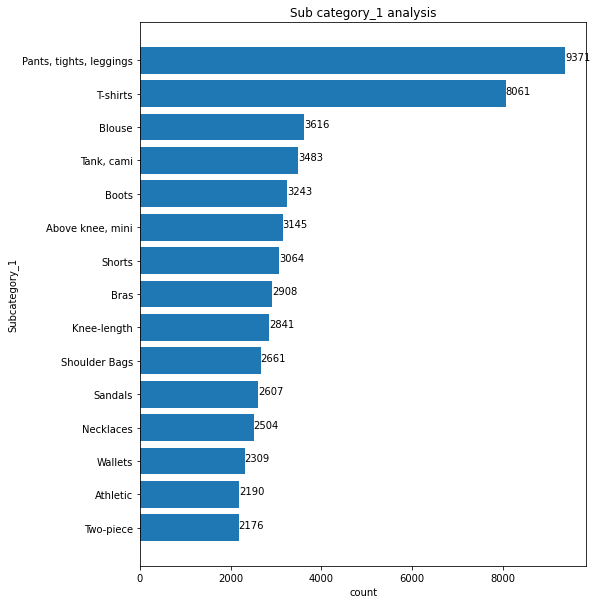

In [470]:
subcat1_count = Counter(list(train_data.subcat_1.values))
x, y = zip(*subcat1_count.most_common(15))

plt.figure(figsize=[8,10])
plt.barh(x,y)
for i, val in enumerate(y):
  plt.annotate(val, (y[i], x[i]))
plt.gca().invert_yaxis()
plt.title('Sub category_1 analysis')
plt.ylabel('Subcategory_1')
plt.xlabel('count')

plt.show()

- ‘Pants,Tights,Leggings’ occur with the maximum frequency in Sub category 1.

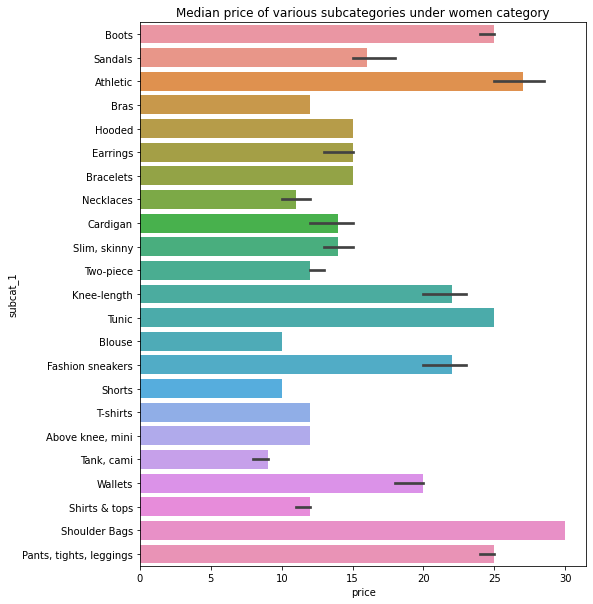

In [471]:
plt.figure(figsize=(8,10))
sns.barplot(y='subcat_1', x='price',data=train_data, estimator=np.median)
plt.title('Median price of various subcategories under women category')
plt.show()

## **3.2 : Plotting Correlation matrix:**

- A correlation matrix is basically a covariance matrix that is a very good technique of multivariate exploration. We have so many features already present in our data set. 
-  A positive value of correlation suggests a stronger association and vice-versa.

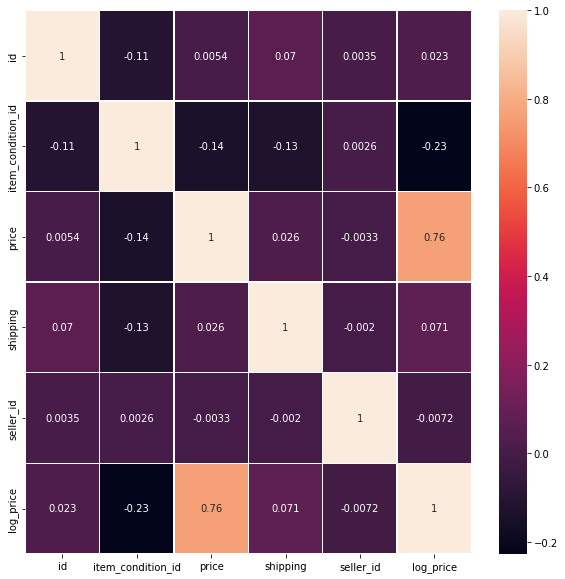

In [472]:
columns = list(train_data.columns)
plt.figure(figsize = (10, 10))
sns.heatmap(train_data[columns].corr(), annot = True, linewidth = 0.5)
plt.show()

In [473]:
y_train = np.log(train_data["price"]+1)
train_ids = train_data['id'].values.astype(np.int32)
train_data.drop(['price', 'id','log_price','main_category', 'seller_id'], axis=1, inplace=True)

In [474]:
y_train

0        4.382027
1        3.465736
2        3.891820
3        4.454347
4        5.303305
           ...   
68395    4.262680
68396    4.262680
68397    4.262680
68398    4.262680
68399    4.262680
Name: price, Length: 68400, dtype: float64

In [475]:
train_data.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,subcat_0,subcat_1
0,"Hold Alyssa Frye Harness boots 12R, Sz 7",3,Women/Shoes/Boots,Frye,1,Good used condition Women's Fyre harness boots...,Shoes,Boots
1,Steve Madden booties,3,Women/Shoes/Boots,Steve Madden,0,"The brand is actually ""Steven"" by Steve Madden...",Shoes,Boots
2,BCBG Tan Booties,1,Women/Shoes/Boots,missing,0,Brand new! Does not include the box.,Shoes,Boots
3,NWT Sorel Caribou boots size 8.5,1,Women/Shoes/Boots,missing,0,New in box. Size 8.5,Shoes,Boots
4,NIB Hunter Tiffany Mint Boots Size 5,1,Women/Shoes/Boots,Hunter,0,Brand new never worn only flaw is as you can s...,Shoes,Boots


In [476]:
train_data.shape

(68400, 8)

In [477]:
test_ids = test_data['id'].values.astype(np.int32)
test_data.drop(['id'], axis=1, inplace=True)

In [478]:
test_data.shape

(31789, 10)

# **4. Splitting the dataset into train and test**

- Before applying any ML model, we will split our data set into train and test. We shall fit on the entire train data and use test part for prediction purpose. Also, we shall evaluate which model performs the best on test data based on our evaluation metric RMSLE.

In [479]:
X=train_data
y=y_train

In [481]:
y

0        4.382027
1        3.465736
2        3.891820
3        4.454347
4        5.303305
           ...   
68395    4.262680
68396    4.262680
68397    4.262680
68398    4.262680
68399    4.262680
Name: price, Length: 68400, dtype: float64

In [482]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68400 entries, 0 to 68399
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               68400 non-null  object
 1   item_condition_id  68400 non-null  int64 
 2   category_name      68400 non-null  object
 3   brand_name         68400 non-null  object
 4   shipping           68400 non-null  int64 
 5   item_description   68400 non-null  object
 6   subcat_0           68400 non-null  object
 7   subcat_1           68400 non-null  object
dtypes: int64(2), object(6)
memory usage: 4.2+ MB


In [483]:
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [484]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54720 entries, 10199 to 15795
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               54720 non-null  object
 1   item_condition_id  54720 non-null  int64 
 2   category_name      54720 non-null  object
 3   brand_name         54720 non-null  object
 4   shipping           54720 non-null  int64 
 5   item_description   54720 non-null  object
 6   subcat_0           54720 non-null  object
 7   subcat_1           54720 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.8+ MB


In [486]:
y_test

47169    3.044522
28027    2.397895
7119     1.386294
9977     1.791759
27406    2.397895
           ...   
24492    2.397895
50011    3.044522
27252    2.397895
24457    2.397895
57351    3.433987
Name: price, Length: 13680, dtype: float64

# **5. Cleaning the data: Pre-processing**

In [489]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [490]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

- I have done some basic text pre-processing like removal of non-alphanumeric characters, regular expressions, stopwords, etc. from item_description.

In [491]:
#for X_train
# Combining all the above stundents 
preprocessed_train_des = []
# tqdm is for printing the status bar
for sentance in tqdm(df_train['item_description'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_train_des.append(sent.lower().strip())

# after preprocesing
preprocessed_train_des[20010]

100%|██████████| 54720/54720 [00:03<00:00, 15553.94it/s]


'gold drusy chunky sparkly fabulous danay earrings kendra scott nwt'

In [492]:
#for X_train
# Combining all the above stundents 
preprocessed_test_des = []
# tqdm is for printing the status bar
for sentance in tqdm(df_test['item_description'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_test_des.append(sent.lower().strip())

# after preprocesing
preprocessed_test_des[1224]

100%|██████████| 13680/13680 [00:00<00:00, 15929.89it/s]


'brand new armour hoodie shirt mesh dark material sides shaded purple white dark purple mesh side active material top hood'

In [493]:
#for X_train
# Combining all the above stundents 

preprocessed_test2 = []
# tqdm is for printing the status bar
for sentance in tqdm(test_data['item_description'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_test2.append(sent.lower().strip())

# after preprocesing
preprocessed_test2[20500]

100%|██████████| 31789/31789 [00:02<00:00, 15604.65it/s]


'brown pewter color beautiful boots wore like new'

### - **Handling Categorical Features: One-Hot Encoding**
> Before applying any machine learning model, our data must fed to such models in proper format. We often encounter numerical,categorical values for data in column. 
> In our problem, most of the data in the columns is of categorical nature. Hence, they have to be converted in proper format to extract relevant information. though there are many ways to handle categorical data, one of the commonest way is to do One-Hot Encoding.

- The One-Hot Encoding is specifically done with respect to train data to avoid data leakage issue. We do not include test data into it because test data is unseen to us. So, if any category appears new while testing, we will ignore that value while converting to One-Hot encoded form.

- So, we have ‘Name’, ‘Brand Name’, ‘Sub category 0’, ‘Sub category 1’ as columns with categorical values. We will convert these categorical values into one-hot encoded form.

In [494]:
# name
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(df_train['name'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_name = vectorizer.transform(df_train['name'].values)
test_name = vectorizer.transform(df_test['name'].values)


print("After vectorizations")
print(train_name.shape)
print(test_name.shape)

print(vectorizer.get_feature_names_out())

After vectorizations
(54720, 1620)
(13680, 1620)
['00' '10' '100' ... 'zoom' 'zumba' 'zx']


In [495]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(df_train['name'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
submission_name2 = vectorizer.transform(test_data['name'].values)



print("After vectorizations")
print(submission_name2.shape)


print(vectorizer.get_feature_names_out())

After vectorizations
(31789, 1620)
['00' '10' '100' ... 'zoom' 'zumba' 'zx']


In [496]:
# brand_name
vectorizer = CountVectorizer()
vectorizer.fit(df_train['brand_name'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_brandname = vectorizer.transform(df_train['brand_name'].values)
test_brandname = vectorizer.transform(df_test['brand_name'].values)


print("After vectorizations")
print(train_brandname.shape)
print(test_brandname.shape)

print(vectorizer.get_feature_names_out())

After vectorizations
(54720, 1305)
(13680, 1305)
['1960' '21' '44' ... 'zoe' 'zoo' 'zumba']


In [497]:
vectorizer = CountVectorizer()
vectorizer.fit(df_train['brand_name'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
submission_brand_name2 = vectorizer.transform(test_data['brand_name'].values)



print("After vectorizations")
print(submission_brand_name2.shape)


print(vectorizer.get_feature_names_out())

After vectorizations
(31789, 1305)
['1960' '21' '44' ... 'zoe' 'zoo' 'zumba']


In [498]:
# sub category_0
vectorizer = CountVectorizer()
vectorizer.fit(df_train['subcat_0'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_subcat_0 = vectorizer.transform(df_train['subcat_0'].values)
# we use the fitted CountVectorizer to convert the text to vector
test_subcat_0 = vectorizer.transform(df_test['subcat_0'].values)


print("After vectorizations")
print(train_subcat_0.shape)
print(test_subcat_0.shape)

print(vectorizer.get_feature_names_out())

After vectorizations
(54720, 14)
(13680, 14)
['accessories' 'apparel' 'athletic' 'blouses' 'dresses' 'handbags' 'jeans'
 'jewelry' 'shoes' 'sweaters' 'swimwear' 'tops' 'underwear' 'women']


In [499]:
vectorizer = CountVectorizer()
vectorizer.fit(df_train['subcat_0'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
submission_subcat_02 = vectorizer.transform(test_data['subcat_0'].values)



print("After vectorizations")
print(submission_subcat_02.shape)

print(vectorizer.get_feature_names_out())

After vectorizations
(31789, 14)
['accessories' 'apparel' 'athletic' 'blouses' 'dresses' 'handbags' 'jeans'
 'jewelry' 'shoes' 'sweaters' 'swimwear' 'tops' 'underwear' 'women']


In [500]:
# sub category_1
vectorizer = CountVectorizer()
vectorizer.fit(df_train['subcat_1'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_subcat_1 = vectorizer.transform(df_train['subcat_1'].values)
test_subcat_1 = vectorizer.transform(df_test['subcat_1'].values)


print("After vectorizations")
print(train_subcat_1.shape)
print(test_subcat_1.shape)

print(vectorizer.get_feature_names_out())

After vectorizations
(54720, 32)
(13680, 32)
['above' 'athletic' 'bags' 'blouse' 'boots' 'bracelets' 'bras' 'cami'
 'cardigan' 'earrings' 'fashion' 'hooded' 'knee' 'leggings' 'length'
 'mini' 'necklaces' 'pants' 'piece' 'sandals' 'shirts' 'shorts' 'shoulder'
 'skinny' 'slim' 'sneakers' 'tank' 'tights' 'tops' 'tunic' 'two' 'wallets']


In [501]:
vectorizer = CountVectorizer()
vectorizer.fit(df_train['subcat_1'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
submission_subcat_12 = vectorizer.transform(test_data['subcat_1'].values)



print("After vectorizations")
print(submission_subcat_12.shape)


print(vectorizer.get_feature_names_out())

After vectorizations
(31789, 32)
['above' 'athletic' 'bags' 'blouse' 'boots' 'bracelets' 'bras' 'cami'
 'cardigan' 'earrings' 'fashion' 'hooded' 'knee' 'leggings' 'length'
 'mini' 'necklaces' 'pants' 'piece' 'sandals' 'shirts' 'shorts' 'shoulder'
 'skinny' 'slim' 'sneakers' 'tank' 'tights' 'tops' 'tunic' 'two' 'wallets']


**Handling Text-Features:**
- Just like categorical features, we also have to treat our text features in the data. The column that bears text feature values in our data is ‘Item Description’. There are different ways of converting text features to numerical format like BOW, TF-IDF, Word2Vec. In this problem, we have computed TF-IDF vectors for all the words in our item description values.

In [502]:
#for preprocessed_essays
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=5000)
vectorizer.fit(preprocessed_train_des)
X_train_itemdes = vectorizer.transform(preprocessed_train_des)
X_test_itemdes = vectorizer.transform(preprocessed_test_des)

In [503]:
print("Shape of train matrix after one hot encodig ",X_train_itemdes.shape)
print("Shape of test matrix after one hot encodig ",X_test_itemdes.shape)

Shape of train matrix after one hot encodig  (54720, 5000)
Shape of test matrix after one hot encodig  (13680, 5000)


In [504]:
#for preprocessed_essays
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=5000)
vectorizer.fit(preprocessed_train_des)
X_submission_itemdes2 = vectorizer.transform(preprocessed_test2)
print("Shape of train matrix after one hot encodig ",X_submission_itemdes2.shape)

Shape of train matrix after one hot encodig  (31789, 5000)


### **Length of Item description:**

- Numerical features can be tricky to handle due to different range of minimum and maximum values for different types of features. In this section, we will handle the numerical features before feeding into our machine learning models.

- Since numerical features can be of different scale values, we have normalized our features and assigned an uniformity so as not to train models with scale differences between features. Scikit Learn has an inbuilt Normalizer library to normalize values in a given range.

In [505]:
X_train_des_wordcount = []
for i in tqdm(preprocessed_train_des):
    cnt_words =1
    for j in i:
        if (j==' '):
            cnt_words+=1
    X_train_des_wordcount.append(cnt_words)

100%|██████████| 54720/54720 [00:00<00:00, 178262.96it/s]


In [506]:
df_train['Number of words in item description']= X_train_des_wordcount

In [507]:
X_test_des_wordcount = []
for i in tqdm(preprocessed_test_des):
    cnt_words =1
    for j in i:
        if (j==' '):
            cnt_words+=1
    X_test_des_wordcount.append(cnt_words)

100%|██████████| 13680/13680 [00:00<00:00, 170865.73it/s]


In [508]:
df_test['Number of words in item description']= X_test_des_wordcount

In [509]:
X_submission_des_wordcount = []
for i in tqdm(preprocessed_test2):
    cnt_words =1
    for j in i:
        if (j==' '):
            cnt_words+=1
    X_submission_des_wordcount.append(cnt_words)

100%|██████████| 31789/31789 [00:00<00:00, 169401.32it/s]


In [510]:
test_data['Number of words in item description']= X_submission_des_wordcount

In [511]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(df_train['Number of words in item description'].values.reshape(-1,1))

#X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_train_words_des_norm = normalizer.transform(df_train['Number of words in item description'].values.reshape(-1,1))

X_test_words_des_norm = normalizer.transform(df_test['Number of words in item description'].values.reshape(-1,1))

print("After normalizations")
print(X_train_words_des_norm.shape, y_train.shape)

print(X_test_words_des_norm.shape, y_test.shape)

After normalizations
(54720, 1) (54720,)
(13680, 1) (13680,)


In [512]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(df_train['Number of words in item description'].values.reshape(-1,1))

submission_words_des_norm2 = normalizer.transform(test_data['Number of words in item description'].values.reshape(-1,1))


print("After normalizations")
print(submission_words_des_norm2.shape)

After normalizations
(31789, 1)


### **Shipping and Item Condition id:**

The columns ‘Shipping’ and ‘Condition id’ are also categorical variables and we have adopted an easier way to One-Hot encode it. Pandas contain get_dummies method which is of the fastest ways to do one-hot encoding on categorical variables. It’s the vector representation of categorical values and the output returned is also of dataframe type. The algorithm in the ‘get_dummies’ method will recognize the categorical features and will obtain the one-hot encoded values automatically.

In [513]:
from scipy.sparse import csr_matrix

X_dummies = csr_matrix(pd.get_dummies(df_train[['item_condition_id', 'shipping']],
                                          sparse=True).values)
X_test_dummies = csr_matrix(pd.get_dummies(df_test[['item_condition_id', 'shipping']],
                                          sparse=True).values)
submission_dummies2 = csr_matrix(pd.get_dummies(test_data[['item_condition_id', 'shipping']],
                                          sparse=True).values)

### **Merging all features in a matrix :**

- After having handled all types of features, we are just step away from our machine learning modelling. For using our converted features, we will merge all of them in a matrix and will convert the matrix to compressed Sparse Row format stack arrays in sequence horizontally (column wise).
- Hstack creates a concatenated form of arrays in sequence horizontally.

In [514]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

In [515]:
X_train = hstack((train_name, train_brandname, train_subcat_0, train_subcat_1, X_train_itemdes, X_dummies, X_train_words_des_norm)).tocsr()

X_test = hstack((test_name, test_brandname, test_subcat_0, test_subcat_1, X_test_itemdes, X_test_dummies, X_test_words_des_norm)).tocsr()

print("Final Data matrix")
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)


Final Data matrix
(54720, 7974) (54720,)
(13680, 7974) (13680,)


In [516]:
submission2 = hstack((submission_name2,submission_brand_name2,submission_subcat_02,submission_subcat_12,X_submission_itemdes2,submission_dummies2,submission_words_des_norm2)).tocsr()


print("Final Data matrix")
print(submission2.shape)

Final Data matrix
(31789, 7974)


# **6. Machine Learning Modelling:**

- After having done with the statistical analysis and cleaning of data, we also did some feature engineering.
- We also handled categorical, text and numerical features and merged into train and test data matrix. We are now ready to apply machine learning algorithms on our prepared data matrices.

- I have experimented with three machine learning regression models:


    1.   Ridge Regression
    2.   SVM Regression
    3.   Light Gradient Boosting Regression


- I have hyperparameter tuned each of these models. From the best hyperparameters that was obtained by training on the train data set, it was used to predict the price values on test data set and compare the RMSLE of each of these ML models. I have tried with a wide range of hyperparameters because the optimal set of hyperparameters varies from problem to problem.
- For model building, we will be using the Scikit-learn library of Python. It is extremely easy to build models with Scikit Learn because of its simplicity.



In [517]:
import warnings
warnings.simplefilter("ignore", UserWarning)


**Ridge Regression**

In [518]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

100%|██████████| 9/9 [00:16<00:00,  1.85s/it]


RMSLE for alpha =  1 is 0.5066129307586151
RMSLE for alpha =  2 is 0.5027917228246782
RMSLE for alpha =  3 is 0.5011254906357
RMSLE for alpha =  3.5 is 0.5006601440650434
RMSLE for alpha =  4 is 0.5003464846702772
RMSLE for alpha =  4.5 is 0.5001413385288395
RMSLE for alpha =  5 is 0.5000250710680421
RMSLE for alpha =  6 is 0.4999583076163308
RMSLE for alpha =  7 is 0.5000418544131613


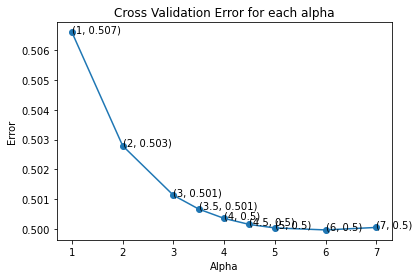

In [519]:
alpha = [1, 2, 3, 3.5, 4, 4.5, 5, 6, 7] 
cv_rmsle_array=[] 
for i in tqdm(alpha):
    model = Ridge(solver="sag", random_state=42, alpha=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cv_rmsle_array.append(np.sqrt(mean_squared_error(y_test, y_pred)))

for i in range(len(cv_rmsle_array)):
    print ('RMSLE for alpha = ',alpha[i],'is',cv_rmsle_array[i])
    
best_alpha = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_rmsle_array)
ax.scatter(alpha, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_rmsle_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [520]:
print("Best alpha: ",  alpha[best_alpha])
model = Ridge(solver="sag", random_state=42, alpha=alpha[best_alpha])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Train RMSLE:', np.sqrt(mean_squared_error(y_test, y_pred)))
predridge2 = model.predict(submission2)

Best alpha:  6
Train RMSLE: 0.4999583076163308


**SVM Regression**

RMSLE for C= 0.01 is 0.8764940821230286
RMSLE for C= 0.03 is 0.8441910209833697
RMSLE for C= 0.1 is 0.7883049238325753
RMSLE for C= 0.3 is 0.7401915276073172
RMSLE for C= 1 is 0.6686070871365313
RMSLE for C= 3 is 0.6206017094026628
RMSLE for C= 10 is 0.6783546520174002


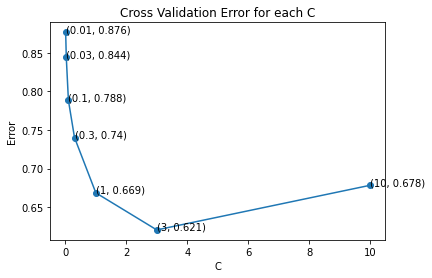

In [521]:
from sklearn.svm import SVR

c_param = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
cv_rmsle_array=[]

for i in c_param:
    model = SVR(C=i, max_iter=200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cv_err = np.sqrt(mean_squared_error(y_test, y_pred))
    cv_rmsle_array.append(cv_err)

    print('RMSLE for C=',i, 'is', cv_err)

best_C = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(c_param, cv_rmsle_array)
ax.scatter(c_param, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((c_param[i],np.round(txt,3)), (c_param[i],cv_rmsle_array[i]))
plt.title("Cross Validation Error for each C")
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

In [522]:
best_C = c_param[best_C]
print('Best C: ', best_C)
model = SVR(C=best_C, max_iter=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('Train RMSLE:', np.sqrt(mean_squared_error(y_test, y_pred)))
predsvm = model.predict(submission2)

Best C:  3
Train RMSLE: 0.6206017094026628


**Light GBM Regressor**

In [527]:
from lightgbm import LGBMRegressor
from scipy.stats import uniform
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

lgb_model = LGBMRegressor(subsample=0.9)

params = {'learning_rate': uniform(0, 1),
          'n_estimators': sp_randint(200, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
         }
lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=42, 
                                scoring='neg_root_mean_squared_error', verbose=10, return_train_score=True)
lgb_random = lgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122
[CV 1/3; 1/10] END colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122;, score=(train=-0.228, test=-0.627) total time= 1.0min
[CV 2/3; 1/10] START colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122
[CV 2/3; 1/10] END colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=1244, num_leaves=122;, score=(train=-0.232, test=-0.625) total time=  53.1s
[CV 3/3; 1/10] START colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.

In [528]:
best_params = lgb_random.best_params_
print(best_params)

{'colsample_bytree': 0.44583275285359114, 'learning_rate': 0.09997491581800289, 'max_depth': 12, 'min_child_weight': 1.7323522915498704, 'n_estimators': 1323, 'num_leaves': 123}


In [529]:
model = LGBMRegressor(**best_params, subsample=0.9, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.44583275285359114,
              learning_rate=0.09997491581800289, max_depth=12,
              min_child_weight=1.7323522915498704, n_estimators=1323,
              num_leaves=123, random_state=42, subsample=0.9)

In [530]:
y_pred = model.predict(X_test)
print('Train RMSLE:', np.sqrt(mean_squared_error(y_test, y_pred)))
predlgm = model.predict(submission2)

Train RMSLE: 0.49807267883584483


In [531]:
submission_final['price'] = np.expm1(predlgm)
submission_final.to_csv("predictionResult.csv", index=False)

In [532]:
df=pd.read_csv('predictionResult.csv')

In [533]:
df.shape

(31789, 2)

In [534]:
df.head(5)

,id,price
0,46,18.680696
1,88,33.057648
2,212,90.668775
3,289,43.474471
4,299,49.169772


# **7. Summary :**

In [536]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "HyperParameters used",  "RMSLE"]

x.add_row(["Ridge Regression", "alpha", 0.499])
x.add_row(["SVM Regression", "C parameter", 0.620])
x.add_row(["Light GBM Regressor","learning_rate, n_estimators , num_leaves , max_depth , min_child_weight , colsample_bytree" ,   0.498])


print(x)

+---------------------+--------------------------------------------------------------------------------------------+-------+
|        Model        |                                    HyperParameters used                                    | RMSLE |
+---------------------+--------------------------------------------------------------------------------------------+-------+
|   Ridge Regression  |                                           alpha                                            | 0.499 |
|    SVM Regression   |                                        C parameter                                         |  0.62 |
| Light GBM Regressor | learning_rate, n_estimators , num_leaves , max_depth , min_child_weight , colsample_bytree | 0.498 |
+---------------------+--------------------------------------------------------------------------------------------+-------+


# **8. Conclusion & Future work**

- Light GBM Regression is give best result (RMSLE=0.498) amoung all the above models.
- In order to get more accurate predictions, we should try Deep Learning models.